# Result analysis of national SIRDS simulations

In [1]:
import matplotlib.dates as mdates
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.ticker as mticker
import util
from PIL import Image
from sirds_model_visualization import get_sirds, get_sirds_extras, show_performance, plot_result, plot_parameters, \
    plot_fuzzy_variables, calculate_performance
import numpy as np

## Reading data

In [2]:
df_covid_brazil = pd.read_csv('data/output/df_ts_epidemic_episodes.csv')
df_covid_brazil.DATA = pd.to_datetime(df_covid_brazil.DATA, infer_datetime_format=True)
df_covid_brazil['TAXA_CASOS_NOVOS_MEDIA_MOVEL_7_DIAS_PAINEL'] = df_covid_brazil.CASOS_NOVOS_MEDIA_MOVEL_7_DIAS_PAINEL / df_covid_brazil.POPULACAO_2022 * 100000

In [3]:
df_covid_brazil.POPULACAO_2022.unique()

array([2.03062512e+08])

In [4]:
df_covid_brazil[df_covid_brazil.DATA == pd.to_datetime('2020-06-07')].CASOS_ACUMULADO_PAINEL 

112    691758.0
Name: CASOS_ACUMULADO_PAINEL, dtype: float64

In [5]:
df_covid_other_countries = pd.read_csv('data/output/df_ts_epidemic_episodes_other_countries.csv')
df_covid_other_countries.date = pd.to_datetime(df_covid_other_countries.date)

In [6]:
df_fitting_recovery_period_brazil = pd.read_csv('data/output/fitting_recovery_period_results.csv')

In [7]:
df_fitting_other_countries = pd.read_csv('data/output/execution_other_countries_results.csv')

In [8]:
df_fitting_other_countries.location.unique()

array(['Spain', 'United Kingdom', 'United States'], dtype=object)

## Show results

### Figure 6

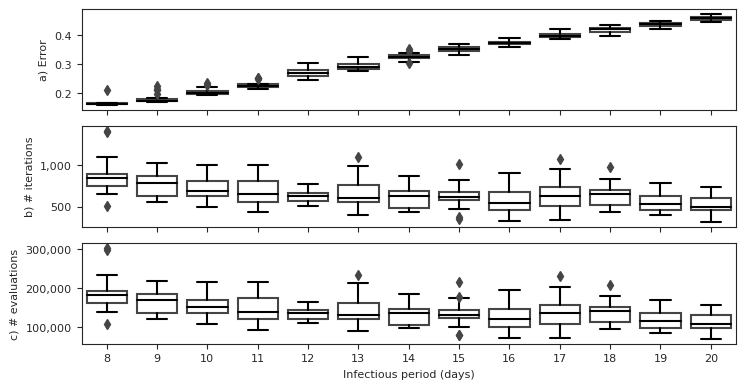

In [9]:
sns.set_style("ticks")
sns.set_palette("gray")
plt.rc('font', size=8)

fig, ax = plt.subplots(3, 1, figsize=(util.centimeter_to_inch(19.05), util.centimeter_to_inch(10)), sharex=True)

sns.boxplot(x=df_fitting_recovery_period_brazil.days_to_recovery.astype(int), y=df_fitting_recovery_period_brazil.result_fun, boxprops=dict(facecolor='white'), ax=ax[0])
ax[0].set_ylabel('a) Error')      
ax[0].set_xlabel(None)
plt.setp(ax[0].artists, edgecolor = 'black')
plt.setp(ax[0].lines, color='black')

sns.boxplot(x=df_fitting_recovery_period_brazil.days_to_recovery.astype(int), y=df_fitting_recovery_period_brazil.result_nit, boxprops=dict(facecolor='white'), ax=ax[1])
ax[1].set_ylabel('b) # iterations')      
ax[1].set_xlabel(None)
plt.setp(ax[1].artists, edgecolor = 'black')
plt.setp(ax[1].lines, color='black')
ax[1].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: format(int(x), ',')))

sns.boxplot(x=df_fitting_recovery_period_brazil.days_to_recovery.astype(int), y=df_fitting_recovery_period_brazil.result_nfev, boxprops=dict(facecolor='white'), ax=ax[2])
ax[2].set_ylabel('c) # evaluations')      
ax[2].set_xlabel(None)
plt.setp(ax[2].artists, edgecolor = 'black')
plt.setp(ax[2].lines, color='black')
ax[2].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax[2].set_xlabel('Infectious period (days)')

plt.tight_layout()

plt.savefig('images/boxplot_sirds_optimization.pdf', bbox_inches="tight")
plt.savefig('images/boxplot_sirds_optimization.tiff', format='tiff', dpi=300, transparent=False, bbox_inches='tight')
img = Image.open("images/boxplot_sirds_optimization.tiff")
img.save("images/boxplot_sirds_optimization_compressed.tiff", compression="tiff_lzw")
plt.show()

### Figure 7

In [10]:
df_prevalence_analysis_simulation = pd.DataFrame()
df_prevalence_analysis_real = pd.DataFrame()

### Brazil

In [11]:
days_to_recovery = 8

df_results = df_fitting_recovery_period_brazil[df_fitting_recovery_period_brazil.days_to_recovery == days_to_recovery].copy()
date_first_case = pd.to_datetime(df_results.date_first_case.unique()[0])
df_covid_brazil = df_covid_brazil[df_covid_brazil.DATA >= date_first_case]

real_reproduction_number = df_covid_brazil.NUMERO_REPRODUCAO_EFETIVO_SRAG_MEDIA.values
real_new_deaths = df_covid_brazil.TAXA_OBITOS_NOVOS_MEDIA_MOVEL_7_DIAS_SIM.values
real_total_deaths = df_covid_brazil.TAXA_OBITOS_NOVOS_MEDIA_MOVEL_7_DIAS_SIM.cumsum().values
real_new_cases = df_covid_brazil.TAXA_CASOS_NOVOS_MEDIA_MOVEL_7_DIAS_PAINEL.values
real_total_cases = df_covid_brazil.TAXA_CASOS_NOVOS_MEDIA_MOVEL_7_DIAS_PAINEL.cumsum().values

df_S = pd.DataFrame()
df_I = pd.DataFrame()
df_R = pd.DataFrame()
df_D = pd.DataFrame()
df_I_accumulated = pd.DataFrame()
df_new_deaths = pd.DataFrame()
df_rt = pd.DataFrame()
df_new_cases = pd.DataFrame()
df_r0 = pd.DataFrame()
df_IFR = pd.DataFrame()
df_Omega = pd.DataFrame()
list_fuzzy_fast_transition = []
list_fuzzy_slow_transition = []

dict_performance = {'mae_fit': [], 'sse_D_fit': [], 'r2_D_fit': [], 'sse_Rt_fit': [], 'r2_Rt_fit': []} 

for index, result in df_results.iterrows():    
    y = get_sirds(result)
    S, I, R, D, I_accumulated = y
    min_length = min(len(real_new_deaths), len(D))
    S = S[:min_length]
    I = I[:min_length]
    R = R[:min_length]
    D = D[:min_length]
    I_accumulated = I_accumulated[:min_length]
    N = S[0] + I[0] + R[0] + D[0]
    
    dates = df_covid_brazil[:min_length].DATA.values
    
    D_new_deaths, reproduction_number_sird, I_new_cases, epidemic_periods_with_fast_transition_fuzzy_variable, epidemic_periods_with_slow_transition_fuzzy_variable, days_between_infections_values, case_fatality_probability_values, loss_immunity_in_days_values, estimated_days_between_infections, estimated_case_fatality_probability, estimated_loss_immunity_in_days = get_sirds_extras(result, S, D, I_accumulated)
    
    df_S_temp = pd.DataFrame({'date': dates, 'S': S})
    df_I_temp = pd.DataFrame({'date': dates, 'I': I})
    df_R_temp = pd.DataFrame({'date': dates, 'R': R})
    df_D_temp = pd.DataFrame({'date': dates, 'D': D})
    df_I_accumulated_temp = pd.DataFrame({'date': dates, 'I_accumulated': I_accumulated})
    df_new_deaths_temp = pd.DataFrame({'date': dates[1:], 'deaths': D_new_deaths})
    df_rt_temp = pd.DataFrame({'date': dates, 'rt': reproduction_number_sird})
    df_new_cases_temp = pd.DataFrame({'date': dates[1:], 'cases': I_new_cases})
    df_r0_temp = pd.DataFrame({'date': dates, 'r0': days_to_recovery/estimated_days_between_infections}) 
    df_IRF_temp = pd.DataFrame({'date': dates, 'ifr': estimated_case_fatality_probability})
    df_Omega_temp = pd.DataFrame({'date': dates, 'Omega': estimated_loss_immunity_in_days})
               
    df_S = pd.concat([df_S, df_S_temp])
    df_I = pd.concat([df_I, df_I_temp])
    df_R = pd.concat([df_R, df_R_temp])
    df_D = pd.concat([df_D, df_D_temp])
    df_I_accumulated = pd.concat([df_I_accumulated, df_I_accumulated_temp])
    df_new_deaths = pd.concat([df_new_deaths, df_new_deaths_temp])
    df_rt = pd.concat([df_rt, df_rt_temp])
    df_new_cases = pd.concat([df_new_cases, df_new_cases_temp])
    df_r0 = pd.concat([df_r0, df_r0_temp])
    df_IFR = pd.concat([df_IFR, df_IRF_temp])
    df_Omega = pd.concat([df_Omega, df_Omega_temp])
    list_fuzzy_fast_transition.append(epidemic_periods_with_fast_transition_fuzzy_variable)
    list_fuzzy_slow_transition.append(epidemic_periods_with_slow_transition_fuzzy_variable)
    
    mae_fit, sse_D_fit, r2_D_fit, sse_Rt_fit, r2_Rt_fit = calculate_performance(real_new_deaths, D_new_deaths, real_reproduction_number,  reproduction_number_sird)
    dict_performance['mae_fit'].append(mae_fit)
    dict_performance['sse_D_fit'].append(sse_D_fit)
    dict_performance['r2_D_fit'].append(r2_D_fit)
    dict_performance['sse_Rt_fit'].append(sse_Rt_fit)
    dict_performance['r2_Rt_fit'].append(r2_Rt_fit)   

In [12]:
df_results.x_initial_infected_population

0      0.032103
13     0.027559
26     0.040446
39     0.032538
52     0.025688
65     0.029992
78     0.032215
91     0.020173
104    0.021813
117    0.035568
130    0.033372
143    0.036032
156    0.031310
169    0.022918
182    0.038990
195    0.035945
208    0.029498
221    0.025129
234    0.035151
247    0.038983
Name: x_initial_infected_population, dtype: float64

In [13]:
mean = np.mean(df_results.x_initial_infected_population.values)
lower_bound, upper_bound = util.calculate_confidence_interval(df_results.x_initial_infected_population.values)
print(mean, '(', lower_bound, ',', upper_bound, ')')

0.03127114745630615 ( 0.02868216428833497 , 0.03371246260389377 )


In [14]:
population = df_covid_brazil.POPULACAO_2022.iloc[0]
population

203062512.0

In [15]:
df_results['x_initial_infected_population_total'] = df_results.x_initial_infected_population * population / 100000
df_results['x_initial_infected_population_total']

0      65.188542
13     55.961930
26     82.131090
39     66.072825
52     52.162028
65     60.902511
78     65.416174
91     40.963336
104    44.293864
117    72.225804
130    67.765361
143    73.166997
156    63.579293
169    46.537479
182    79.174519
195    72.991615
208    59.898800
221    51.028386
234    71.378490
247    79.160506
Name: x_initial_infected_population_total, dtype: float64

In [16]:
mean = np.mean(df_results.x_initial_infected_population_total.values)
lower_bound, upper_bound = util.calculate_confidence_interval(df_results.x_initial_infected_population_total.values)
print(mean, '(', lower_bound, ',', upper_bound, ')')

63.499977555999386 ( 57.93132058336984 , 68.5604380128713 )


In [17]:
r0 = df_r0[df_r0.date == df_r0.date.min()].r0.values
r0

array([2.38662622, 2.44978497, 2.43209143, 2.43980105, 2.4457322 ,
       2.43399845, 2.43553204, 2.4867989 , 2.51142019, 2.4742102 ,
       2.39510695, 2.42350885, 2.50317346, 2.4757685 , 2.40506932,
       2.39846079, 2.45528742, 2.46765773, 2.44304427, 2.37389459])

In [18]:
mean = np.mean(r0)
lower_bound, upper_bound = util.calculate_confidence_interval(r0)
print(mean, '(', lower_bound, ',', upper_bound, ')')

2.441848377061091 ( 2.42557340562596 , 2.4594353864737575 )


In [19]:
min_date_r0_min = df_r0[df_r0.r0 == df_r0.r0.min()].date.min()
max_date_r0_min = df_r0[df_r0.r0 == df_r0.r0.min()].date.max()

In [20]:
df_r0[(df_r0.date >= min_date_r0_min) & (df_r0.date <= max_date_r0_min)].groupby('date').describe()

r0                                                              \
           count      mean       std       min       25%       50%       75%   
date                                                                           
2020-05-18  20.0  1.002826  0.021079  0.963665  0.987429  1.007997  1.012677   
2020-05-19  20.0  1.004961  0.021300  0.963665  0.989332  1.009553  1.015618   
2020-05-20  20.0  1.006980  0.021612  0.963665  0.993395  1.010684  1.017367   
2020-05-21  20.0  1.008910  0.021968  0.963665  0.997111  1.013256  1.019312   

                      
                 max  
date                  
2020-05-18  1.060386  
2020-05-19  1.062315  
2020-05-20  1.064077  
2020-05-21  1.065691

In [21]:
r0_min = df_r0[df_r0.date == min_date_r0_min].r0.values
r0_min

array([0.97061585, 0.98464736, 1.06038618, 0.96366495, 0.98542267,
       1.01128248, 1.00579157, 0.98810398, 1.01393102, 1.01683819,
       0.98809721, 1.01240786, 1.01183453, 1.01348584, 1.00367887,
       1.01215199, 1.00022895, 0.98379524, 1.01994852, 1.01020157])

In [22]:
mean = np.mean(r0_min)
lower_bound, upper_bound = util.calculate_confidence_interval(r0_min)
print(mean, '(', lower_bound, ',', upper_bound, ')')

1.0028257421800142 ( 0.9938669746540416 , 1.0122052445372378 )


In [23]:
r0_max = df_r0[df_r0.date == df_r0.date.max()].r0.values
r0_max

array([5.41508876, 5.28986919, 5.48592745, 5.14303038, 5.2391656 ,
       5.48390797, 5.38188029, 5.44642392, 5.4409023 , 1.89783255,
       5.19064471, 5.35540411, 5.48387531, 5.44418654, 5.29857776,
       5.51560058, 5.49363499, 5.38705983, 5.36780819, 5.24260793])

In [24]:
mean = np.mean(r0_max)
lower_bound, upper_bound = util.calculate_confidence_interval(r0_max)
print(mean, '(', lower_bound, ',', upper_bound, ')')

5.200171417485887 ( 4.831945886376803 , 5.409762347931805 )


In [25]:
ifr_0 = df_IFR[df_IFR.date == df_IFR.date.min()].ifr.values * 100
ifr_0

array([1.19902791, 0.93100553, 0.59864122, 0.68941696, 1.05295657,
       1.04293403, 0.84160503, 1.00282095, 0.94216152, 0.7815934 ,
       1.02732048, 0.87782497, 0.62037503, 0.91078916, 0.81241339,
       0.83987684, 0.85608816, 0.87300258, 0.72051656, 0.93772253])

In [26]:
mean = np.mean(ifr_0)
lower_bound, upper_bound = util.calculate_confidence_interval(ifr_0)
print(mean, '(', lower_bound, ',', upper_bound, ')')

0.8779046409888949 ( 0.8173018270122218 , 0.9436476279461726 )


In [27]:
ifr_min = df_IFR[df_IFR.date == df_IFR.date.max()].ifr.values * 100
ifr_min

array([0.01063575, 0.01064839, 0.0099    , 0.01462609, 0.01250112,
       0.01003597, 0.01065934, 0.01187187, 0.0119922 , 0.14883303,
       0.01389427, 0.01115306, 0.01117409, 0.01285394, 0.01117999,
       0.01112851, 0.01131794, 0.01323419, 0.01143719, 0.01220289])

In [28]:
mean = np.mean(ifr_min)
lower_bound, upper_bound = util.calculate_confidence_interval(ifr_min)
print(mean, '(', lower_bound, ',', upper_bound, ')')

0.018563991717187 ( 0.01129558499853795 , 0.03261789164394682 )


In [29]:
immunity_period_0 = df_Omega[df_Omega.date == df_Omega.date.min()].Omega.values
immunity_period_0

array([139.34195822, 232.35579986, 263.3868923 , 292.85943673,
       254.68307808, 269.99564468, 347.59616343, 217.56270423,
       155.70872228, 159.5933946 , 146.63209652, 295.09860146,
       191.37512112, 234.06932729, 251.05482385, 195.83338267,
       138.92547419, 290.81187899, 261.76317295, 334.63254843])

In [30]:
mean = np.mean(immunity_period_0)
lower_bound, upper_bound = util.calculate_confidence_interval(immunity_period_0)
print(mean, '(', lower_bound, ',', upper_bound, ')')

233.66401109313634 ( 206.65158007182208 , 261.0301555043693 )


In [31]:
immunity_period_max = df_Omega[df_Omega.date == df_Omega.date.max()].Omega.values
immunity_period_max

array([363.47881017, 276.8694664 , 320.35009773, 344.25639792,
       357.95086315, 352.87279906, 342.22355293, 361.51622134,
       346.08693017, 247.00812787, 359.37764104, 334.53369574,
       316.72795907, 359.168722  , 356.84966292, 357.09129926,
       350.43614152, 355.79655677, 356.31355692, 356.65365898])

In [32]:
mean = np.mean(immunity_period_max)
lower_bound, upper_bound = util.calculate_confidence_interval(immunity_period_max)
print(mean, '(', lower_bound, ',', upper_bound, ')')

340.7781080464163 ( 325.4342721393185 , 352.18529191908186 )


In [33]:
I_accumulated = df_I_accumulated[df_I_accumulated.date == pd.to_datetime('2020-06-04')].I_accumulated.values
I_accumulated

array([2742.70766526, 3659.27100345, 6150.67298685, 4894.39205875,
       3361.94006762, 2997.81649645, 3909.68153757, 3381.8023998 ,
       3920.11966193, 4364.29143609, 3327.19255   , 3998.75820839,
       5546.99455136, 3619.03820214, 4685.28629927, 4377.39213036,
       3932.52494637, 3857.37456493, 4774.87380523, 3613.11286631])

In [34]:
mean = np.mean(I_accumulated)
lower_bound, upper_bound = util.calculate_confidence_interval(I_accumulated)
print(mean, '(', lower_bound, ',', upper_bound, ')')

4055.7621719065355 ( 3719.586888970059 , 4409.650311533133 )


In [35]:
date_final = df_I_accumulated.date.max() 
I_final = df_I_accumulated[df_I_accumulated.date == date_final].I_accumulated.values
I_final

array([232206.97202459, 241254.90576655, 252336.49694129, 226484.58190404,
       232055.54642307, 242580.75732757, 231434.56911736, 231077.04510916,
       236496.23507328, 176870.39783329, 223325.23814345, 230327.15085866,
       235609.98927771, 239438.99005643, 230965.23634753, 230308.45201143,
       236747.16294842, 231394.38762062, 227259.70015735, 232965.41311571])

In [36]:
mean = np.mean(I_final)
lower_bound, upper_bound = util.calculate_confidence_interval(I_final)
print(round(mean), '(', round(lower_bound), ',', round(upper_bound), ')')

231057 ( 224643 , 236138 )


In [37]:
df_covid_brazil_2020 = df_covid_brazil[df_covid_brazil.DATA <= pd.to_datetime('2020-12-31')] 
rate_actual_cases_2020 = round((df_covid_brazil_2020.CASOS_ACUMULADO_PAINEL / df_covid_brazil_2020.POPULACAO_2022 * 100000).iloc[-1])
rate_actual_cases_2020

3780

In [38]:
I_2020 = df_I_accumulated[df_I_accumulated.date == pd.to_datetime('2020-12-31')].I_accumulated.values
I_2020

array([13333.70000403, 19038.16357216, 36496.47933393, 25173.06914724,
       17986.33353099, 13625.89937169, 18841.06064072, 17790.63948595,
       24870.77003308, 23568.52617376, 18534.17973936, 21171.8801541 ,
       29466.38314748, 17630.5785706 , 30115.09629687, 27713.42030749,
       20081.06470363, 19698.72457369, 24610.13665359, 18848.12790998])

In [39]:
mean = np.mean(I_2020/rate_actual_cases_2020)
lower_bound, upper_bound = util.calculate_confidence_interval(I_2020/rate_actual_cases_2020)
print(round(mean,1), '(', round(lower_bound,1), ',', round(upper_bound,1), ')')

5.8 ( 5.2 , 6.5 )


In [40]:
df_covid_brazil_2021 = df_covid_brazil[df_covid_brazil.DATA <= pd.to_datetime('2021-12-31')] 
rate_actual_cases_2021 = round((df_covid_brazil_2021.CASOS_ACUMULADO_PAINEL / df_covid_brazil_2021.POPULACAO_2022 * 100000).iloc[-1]) - rate_actual_cases_2020
rate_actual_cases_2021

7196

In [41]:
I_2021 = df_I_accumulated[df_I_accumulated.date == pd.to_datetime('2021-12-31')].I_accumulated.values - I_2020
I_2021

array([ 97456.89164097,  98898.27564543,  96995.89827611,  80611.67833592,
        86668.86079869, 106514.34459605,  84579.96333419,  92540.93162362,
        95992.92964731,  99775.18960338,  85115.94450764,  87978.03173008,
        92219.51689817, 101790.88373177,  85480.17474443,  85510.07174851,
        97435.88923413,  94739.60128435,  87497.2465873 ,  97731.62746631])

In [42]:
mean = np.mean(I_2021/rate_actual_cases_2021)
lower_bound, upper_bound = util.calculate_confidence_interval(I_2021/rate_actual_cases_2021)
print(round(mean,1), '(', round(lower_bound,1), ',', round(upper_bound,1), ')')

12.9 ( 12.5 , 13.3 )


In [43]:
df_covid_brazil_2022 = df_covid_brazil[df_covid_brazil.DATA <= pd.to_datetime('2022-12-31')] 
rate_actual_cases_2022 = round((df_covid_brazil_2022.CASOS_ACUMULADO_PAINEL / df_covid_brazil_2022.POPULACAO_2022 * 100000).iloc[-1]) - rate_actual_cases_2020 - rate_actual_cases_2021
rate_actual_cases_2022

6916

In [44]:
I_2022 = df_I_accumulated[df_I_accumulated.date == pd.to_datetime('2022-12-31')].I_accumulated.values - I_2020 - I_2021
I_2022

array([121416.38037959, 123318.46654897, 118844.11933124, 120699.83442088,
       127400.35209339, 122440.51335983, 128013.54514245, 120745.47399958,
       115632.53539289,  53526.68205615, 119675.11389645, 121177.23897448,
       113924.08923205, 120017.52775406, 115369.96530622, 117084.95995543,
       119230.20901066, 116956.06176258, 115152.31691646, 116385.65773942])

In [45]:
mean = np.mean(I_2022/rate_actual_cases_2022)
lower_bound, upper_bound = util.calculate_confidence_interval(I_2022/rate_actual_cases_2022)
print(round(mean,1), '(', round(lower_bound,1), ',', round(upper_bound,1), ')')

16.8 ( 15.7 , 17.5 )


In [46]:
round((df_covid_brazil.CASOS_ACUMULADO_PAINEL / df_covid_brazil.POPULACAO_2022 * 100000).iloc[-1])

17892

In [47]:
I_2020_06_24 = df_I_accumulated[df_I_accumulated.date == pd.to_datetime('2020-06-24')].I_accumulated.values
I_2020_06_24

array([3816.06032048, 5155.79321299, 8869.13799278, 6878.31074527,
       4733.65561711, 4185.13497769, 5468.64373426, 4755.93774182,
       5604.50253758, 6174.39302561, 4730.57582045, 5635.73665922,
       7859.56018008, 5068.48624598, 6673.39288971, 6301.70016093,
       5528.01771825, 5406.36207392, 6743.91896419, 5086.58172448])

In [48]:
D_2020_06_24 = df_D[df_D.date == pd.to_datetime('2020-06-24')].D.values
D_2020_06_24

array([34.34172379, 34.30593841, 34.52851671, 33.6741877 , 34.61899991,
       34.78595413, 34.28195812, 33.93783551, 34.18718681, 33.87004346,
       33.64111025, 34.25240312, 33.84490768, 34.37349044, 34.4253432 ,
       33.88330653, 34.08170224, 34.23511552, 34.31205416, 34.13808491])

In [49]:
IFR_2020_06_24 = D_2020_06_24 / I_2020_06_24 * 100
IFR_2020_06_24

array([0.89992613, 0.66538624, 0.38931085, 0.48957061, 0.73133753,
       0.83117879, 0.62688227, 0.71358873, 0.60999503, 0.54855665,
       0.71114197, 0.60777153, 0.43062089, 0.6781806 , 0.51585968,
       0.53768516, 0.61652665, 0.63323756, 0.50878509, 0.67114001])

In [50]:
mean = np.mean(IFR_2020_06_24)
lower_bound, upper_bound = util.calculate_confidence_interval(IFR_2020_06_24)
print(round(mean,2), '(', round(lower_bound,2), ',', round(upper_bound,2), ')')

0.62 ( 0.57 , 0.68 )


In [51]:
I_2020_04_06 = df_I_accumulated[df_I_accumulated.date == pd.to_datetime('2020-04-06')].I_accumulated.values
I_2020_04_06

array([103.89621843, 122.57781377, 188.04127952, 155.82654974,
       116.89809806, 119.09945235, 141.30182171, 114.11182371,
       124.44290265, 162.36063667, 118.50958813, 148.11414527,
       178.13072217, 128.78267222, 160.3328247 , 145.36179088,
       141.29331662, 131.41216545, 165.55096229, 140.16939473])

In [52]:
df_covid_brazil_2020_04_06 = df_covid_brazil[df_covid_brazil.DATA <= pd.to_datetime('2020-04-06')] 
rate_actual_cases_2020_04_06 = (df_covid_brazil_2020_04_06.CASOS_ACUMULADO_PAINEL / df_covid_brazil_2020_04_06.POPULACAO_2022 * 100000).iloc[-1]
rate_actual_cases_2020_04_06

5.937087984019423

In [53]:
percentual_reported_2020_04_06 = rate_actual_cases_2020_04_06 / I_2020_04_06 * 100
percentual_reported_2020_04_06

array([5.71444089, 4.84352576, 3.15733226, 3.81006189, 5.07885764,
       4.98498345, 4.20170661, 5.20286837, 4.77093338, 3.65672869,
       5.00979548, 4.00845441, 3.33299496, 4.61016058, 3.70297723,
       4.08435253, 4.20195953, 4.51791352, 3.58626003, 4.23565215])

In [54]:
mean = np.mean(percentual_reported_2020_04_06)
lower_bound, upper_bound = util.calculate_confidence_interval(percentual_reported_2020_04_06)
print(round(mean,2), '(', round(lower_bound,2), ',', round(upper_bound,2), ')')

4.34 ( 4.06 , 4.64 )


In [55]:
I_2020_05_31 = df_I_accumulated[df_I_accumulated.date == pd.to_datetime('2020-05-31')].I_accumulated.values
I_2020_05_31

array([2534.71293828, 3369.41521626, 5625.93974179, 4513.4678698 ,
       3096.26199419, 2767.59058365, 3600.70577558, 3114.48963006,
       3595.0739162 , 4017.58294292, 3065.01434785, 3679.51104786,
       5096.93508757, 3332.83660926, 4303.45270638, 4017.05133724,
       3621.54159714, 3554.77265939, 4389.61153499, 3326.26419267])

In [56]:
df_covid_brazil_2020_05_31 = df_covid_brazil[df_covid_brazil.DATA <= pd.to_datetime('2020-05-31')] 
rate_actual_cases_2020_05_31 = (df_covid_brazil_2020_05_31.CASOS_ACUMULADO_PAINEL / df_covid_brazil_2020_05_31.POPULACAO_2022 * 100000).iloc[-1]
rate_actual_cases_2020_05_31

253.22251504502222

In [57]:
factor_underreporting_2020_05_31 = I_2020_05_31/rate_actual_cases_2020_05_31
factor_underreporting_2020_05_31

array([10.00982451, 13.30614387, 22.21737566, 17.82411753, 12.2274356 ,
       10.92948067, 14.21953247, 12.29941828, 14.19729172, 15.86582039,
       12.10403564, 14.53074205, 20.12828554, 13.16169144, 16.99474751,
       15.86372103, 14.30181513, 14.03813819, 17.33499699, 13.13573634])

In [58]:
mean = np.mean(factor_underreporting_2020_05_31)
lower_bound, upper_bound = util.calculate_confidence_interval(factor_underreporting_2020_05_31)
print(round(mean,0), '(', round(lower_bound,0), ',', round(upper_bound,0), ')')

15.0 ( 14.0 , 16.0 )


In [59]:
I_2020_09_03 = df_I_accumulated[df_I_accumulated.date == pd.to_datetime('2020-09-03')].I_accumulated.values
I_2020_09_03

array([ 7543.04444228, 10455.80001812, 18688.36934944, 14119.19212759,
        9689.31503793,  8013.82990138, 10765.26185514,  9721.83305447,
       12124.21071108, 12732.01496892,  9859.10564445, 11503.19973719,
       16218.03152124,  9966.02810703, 14652.55379261, 13739.0028868 ,
       11250.76892851, 10923.69790414, 13745.73366584, 10316.61067997])

In [60]:
df_covid_brazil_2020_09_03 = df_covid_brazil[df_covid_brazil.DATA <= pd.to_datetime('2020-09-03')] 
rate_actual_cases_2020_09_03 = (df_covid_brazil_2020_09_03.CASOS_ACUMULADO_PAINEL / df_covid_brazil_2020_09_03.POPULACAO_2022 * 100000).iloc[-1]
rate_actual_cases_2020_09_03

1990.3417721927917

In [61]:
percentual_reported_2020_09_03 = rate_actual_cases_2020_09_03 / I_2020_09_03 * 100
percentual_reported_2020_09_03

array([26.38645162, 19.03576741, 10.65016286, 14.09671144, 20.5416148 ,
       24.83633664, 18.48855884, 20.4729063 , 16.41625851, 15.63257487,
       20.18785318, 17.30250554, 12.27240044, 19.97126389, 13.58358277,
       14.48679929, 17.69071772, 18.22040292, 14.47970564, 19.2925936 ])

In [62]:
mean = np.mean(percentual_reported_2020_09_03)
lower_bound, upper_bound = util.calculate_confidence_interval(percentual_reported_2020_09_03)
print(round(mean,2), '(', round(lower_bound,2), ',', round(upper_bound,2), ')')

17.7 ( 16.06 , 19.42 )


In [63]:
I_2020_06_07 = df_I_accumulated[df_I_accumulated.date == pd.to_datetime('2020-06-07')].I_accumulated.values
I_2020_06_07

array([2899.82798367, 3878.58312   , 6547.95305324, 5182.41871158,
       3562.80825339, 3172.24977994, 4141.96701928, 3583.74926873,
       4166.27753512, 4627.50832271, 3527.14302387, 4239.6365391 ,
       5886.51080948, 3834.39028788, 4973.94424307, 4651.41260802,
       4167.28092044, 4085.61417086, 5065.41242985, 3829.92987626])

In [64]:
df_covid_brazil_2020_06_07 = df_covid_brazil[df_covid_brazil.DATA <= pd.to_datetime('2020-06-07')] 
rate_actual_cases_2020_06_07 = (df_covid_brazil_2020_06_07.CASOS_ACUMULADO_PAINEL / df_covid_brazil_2020_06_07.POPULACAO_2022 * 100000).iloc[-1]
rate_actual_cases_2020_06_07

340.66258374662476

In [65]:
factor_underreporting_2020_06_07 = I_2020_06_07 / rate_actual_cases_2020_06_07
factor_underreporting_2020_06_07

array([ 8.51231724, 11.3854098 , 19.22122759, 15.21276171, 10.4584666 ,
        9.31199941, 12.15856163, 10.51993803, 12.22992408, 13.58384673,
       10.35377289, 12.4452662 , 17.27959304, 11.25568369, 14.6007941 ,
       13.6540167 , 12.23286947, 11.99314033, 14.86929493, 11.24259035])

In [66]:
mean = np.mean(factor_underreporting_2020_06_07)
lower_bound, upper_bound = util.calculate_confidence_interval(factor_underreporting_2020_06_07)
print(round(mean,1), '(', round(lower_bound,1), ',', round(upper_bound,1), ')')	

12.6 ( 11.5 , 13.8 )


In [67]:
len(df_covid_brazil)

1050

In [68]:
rate_actual_deaths_2020 = round((df_covid_brazil_2020.OBITOS_ACUMULADO_PAINEL / df_covid_brazil_2020.POPULACAO_2022 * 100000).iloc[-1])
rate_actual_deaths_2020

96

In [69]:
rate_actual_deaths_2020 / rate_actual_cases_2020 * 100

2.5396825396825395

In [70]:
rate_actual_deaths_2021 = round((df_covid_brazil_2021.OBITOS_ACUMULADO_PAINEL / df_covid_brazil_2021.POPULACAO_2022 * 100000).iloc[-1]) -  rate_actual_deaths_2020
rate_actual_deaths_2021

209

In [71]:
rate_actual_deaths_2022 = round((df_covid_brazil_2022.OBITOS_ACUMULADO_PAINEL / df_covid_brazil_2022.POPULACAO_2022 * 100000).iloc[-1]) -  rate_actual_deaths_2020 -  rate_actual_deaths_2021
rate_actual_deaths_2022

37

In [72]:
rate_actual_deaths_2022 / rate_actual_cases_2022 * 100

0.5349913244650087

In [73]:
D_2020 = df_D[df_D.date == pd.to_datetime('2020-12-31')].D.values
D_2020

array([104.55022724, 104.79018982, 104.40638791, 104.27801393,
       104.27624567, 106.28531933, 103.85722005, 103.76661688,
       105.20259523, 104.40668668, 104.56008814, 102.32503893,
       103.63693275, 104.02228169, 104.53142164, 104.0182393 ,
       104.01131297, 105.23133987, 103.56194568, 104.17490833])

In [74]:
D_2021 = df_D[df_D.date == pd.to_datetime('2021-12-31')].D.values - D_2020
D_2021

array([209.48655148, 213.68275262, 210.2621634 , 209.78847856,
       208.36597859, 210.03595976, 208.25621839, 211.47142338,
       213.22335451, 208.60564981, 208.32765879, 212.39406392,
       209.41334273, 209.33507343, 213.92066754, 211.60997376,
       210.0931487 , 211.44469301, 210.44322304, 210.34492668])

In [75]:
D_2022 = df_D[df_D.date == pd.to_datetime('2022-12-31')].D.values - D_2020 - D_2021
D_2022

array([34.56696188, 32.57489809, 32.57065845, 31.35553277, 35.38421539,
       31.33633677, 34.70449595, 33.90225593, 34.75154992, 32.87605438,
       36.53375236, 33.68920633, 31.95270821, 30.09776358, 34.66254742,
       33.19620391, 36.78714794, 30.67747574, 33.81213986, 33.15385971])

In [76]:
IFR_2020 = D_2020 / I_2020 * 100
IFR_2020

array([0.78410514, 0.55042173, 0.28607249, 0.41424434, 0.57975265,
       0.78002425, 0.5512281 , 0.58326524, 0.42299694, 0.44299201,
       0.56414737, 0.48330634, 0.35171243, 0.5900106 , 0.34710638,
       0.37533526, 0.51795716, 0.53420382, 0.42081012, 0.55270693])

In [77]:
IFR_2022 = D_2022 / I_2022 * 100
IFR_2022

array([0.02846977, 0.02641526, 0.0274062 , 0.02597811, 0.02777403,
       0.02559311, 0.02711002, 0.02807745, 0.03005344, 0.06141994,
       0.03052744, 0.0278016 , 0.02804737, 0.02507781, 0.03004469,
       0.02835224, 0.03085388, 0.02622992, 0.02936297, 0.02848621])

In [78]:
IFR_reduction = (IFR_2020 - IFR_2022) / IFR_2020 * 100
IFR_reduction

array([96.36913896, 95.20090467, 90.41984044, 93.72879601, 95.20933064,
       96.7189339 , 95.08188737, 95.18616014, 92.89511735, 86.13520419,
       94.58874674, 94.2476244 , 92.02548299, 95.74960063, 91.34424184,
       92.44615721, 94.04315952, 95.08990502, 93.02227579, 94.84605567])

In [79]:
mean = np.mean(IFR_reduction)
lower_bound, upper_bound = util.calculate_confidence_interval(IFR_reduction)
print(round(mean,0), '(', round(lower_bound,0), ',', round(upper_bound,0), ')')

94.0 ( 93.0 , 95.0 )


mae_fit :  0.16539675633067602 ( 0.16220841382495987 , 0.170808402070504 )
sse_D_fit :  0.003948270379633105 ( 0.0037679528993502217 , 0.004127355671321978 )
r2_D_fit :  0.9672746273740918 ( 0.9655598863929937 , 0.9688734484415117 )
sse_Rt_fit :  0.009011854242595905 ( 0.007907556545186892 , 0.011066627805541001 )
r2_Rt_fit :  0.8724792491000521 ( 0.8435541776088571 , 0.8884590797316582 )


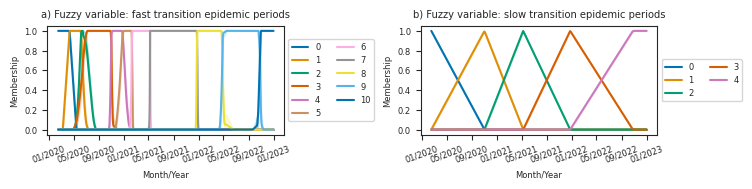

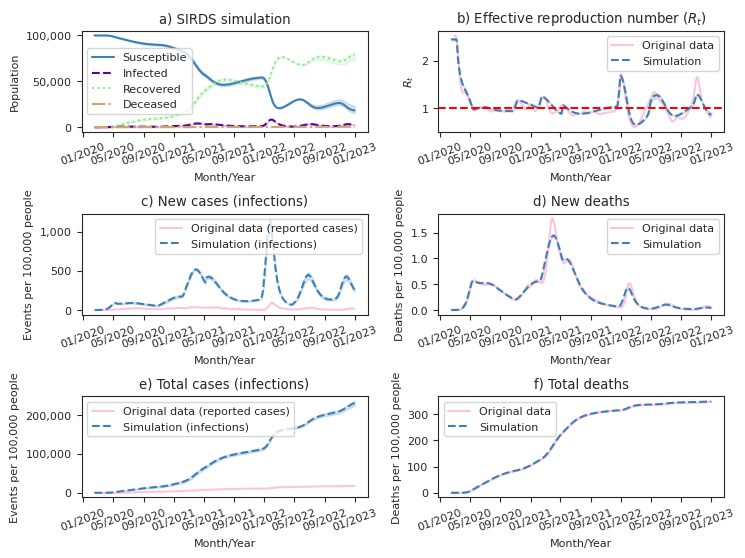

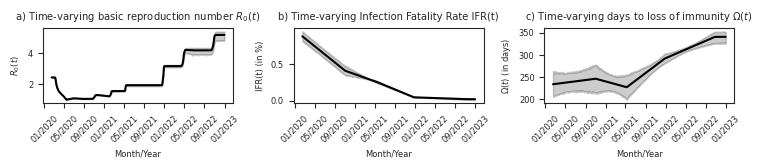

In [80]:
last_prevalence_study_brazil = pd.to_datetime('2020-06-07') + pd.DateOffset(days=0)
df_prevalence_analysis_simulation_temp = df_I_accumulated[df_I_accumulated.date <= last_prevalence_study_brazil].copy()
df_prevalence_analysis_simulation_temp['country'] = 'Brazil'
df_prevalence_analysis_simulation = pd.concat([df_prevalence_analysis_simulation, df_prevalence_analysis_simulation_temp])

df_prevalence_analysis_real_temp = df_covid_brazil[df_covid_brazil.DATA <= last_prevalence_study_brazil][['DATA', 'TAXA_CASOS_NOVOS_MEDIA_MOVEL_7_DIAS_PAINEL']].copy()
df_prevalence_analysis_real_temp = df_prevalence_analysis_real_temp.rename(columns={'DATA': 'date', 'TAXA_CASOS_NOVOS_MEDIA_MOVEL_7_DIAS_PAINEL': 'rate_new_cases_moving_average'})
df_prevalence_analysis_real_temp['rate_new_cases_moving_average'] = df_prevalence_analysis_real_temp['rate_new_cases_moving_average'].cumsum() 
df_prevalence_analysis_real_temp['country'] = 'Brazil'
df_prevalence_analysis_real = pd.concat([df_prevalence_analysis_real, df_prevalence_analysis_real_temp])

show_performance(dict_performance)

plot_fuzzy_variables(dates, list_fuzzy_fast_transition, list_fuzzy_slow_transition, 'brazil')     

plot_result(df_S, df_I, df_R, df_D, df_new_deaths, df_I_accumulated, real_new_deaths[:min_length], real_total_deaths[:min_length], real_reproduction_number[:min_length], df_rt, real_total_cases[:min_length], real_new_cases[:min_length], df_new_cases, df_covid_brazil[:min_length].DATA.values, id_in_file='brazil')

plot_parameters(df_r0, df_IFR, df_Omega, 'brazil')

### Other countries

Spain
mae_fit :  0.25599887511898833 ( 0.2510892972962633 , 0.2626235914679646 )
sse_D_fit :  0.0038698860655001083 ( 0.0037242685004201096 , 0.003999375860535238 )
r2_D_fit :  0.9511625389731879 ( 0.9486809378931402 , 0.9535207024878879 )
sse_Rt_fit :  0.05429965238369018 ( 0.04417400768045483 , 0.07227119381982376 )
r2_Rt_fit :  0.7863395375415629 ( 0.7157556083439756 , 0.8265328047818794 )


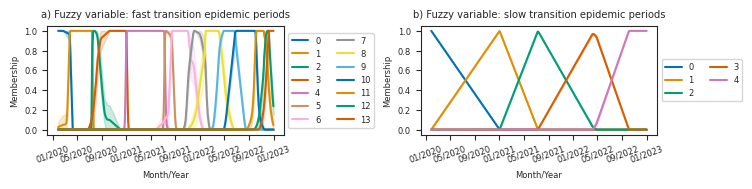

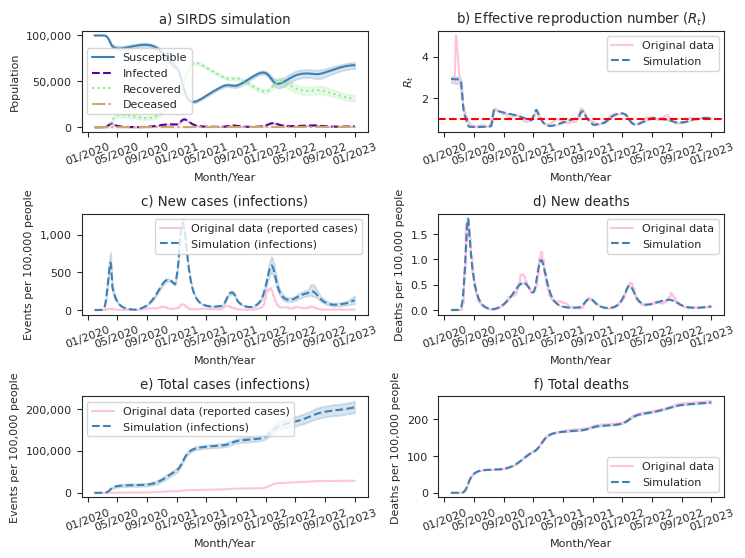

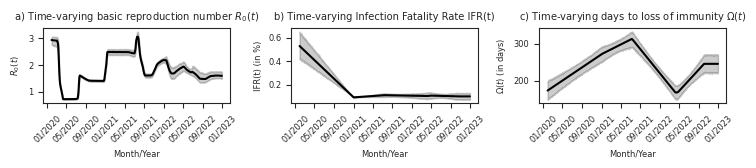

United Kingdom
mae_fit :  0.26025238295793884 ( 0.24433187589914507 , 0.2743805896393481 )
sse_D_fit :  0.009298309776403208 ( 0.007167689640466101 , 0.01153083595218773 )
r2_D_fit :  0.9427474735521603 ( 0.9259544404458995 , 0.9568628134532411 )
sse_Rt_fit :  0.04373624592965633 ( 0.04215374459105035 , 0.0453795037759996 )
r2_Rt_fit :  0.7109462941518615 ( 0.6988226897413111 , 0.7217583820486518 )


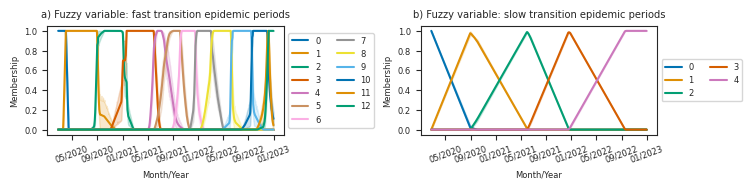

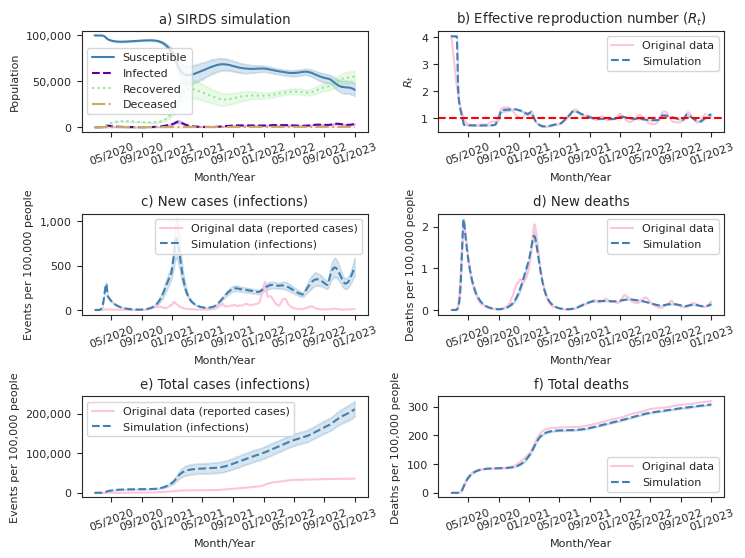

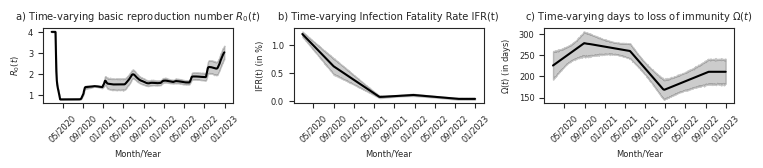

United States
mae_fit :  0.12586345163148022 ( 0.12329791365336898 , 0.1289426793468433 )
sse_D_fit :  0.0015409230572394985 ( 0.0014746229701429478 , 0.0016177379689454672 )
r2_D_fit :  0.9714998420623615 ( 0.9699803262075349 , 0.9727634048169407 )
sse_Rt_fit :  0.003917919583787691 ( 0.0037042946512352054 , 0.004136279684481352 )
r2_Rt_fit :  0.9631597339583802 ( 0.9607188485414243 , 0.9652021808750266 )


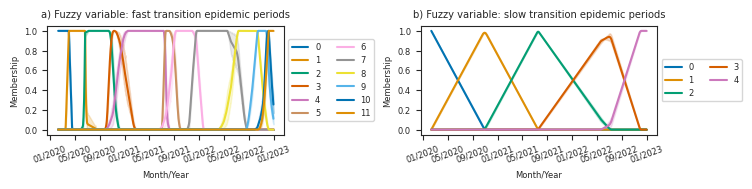

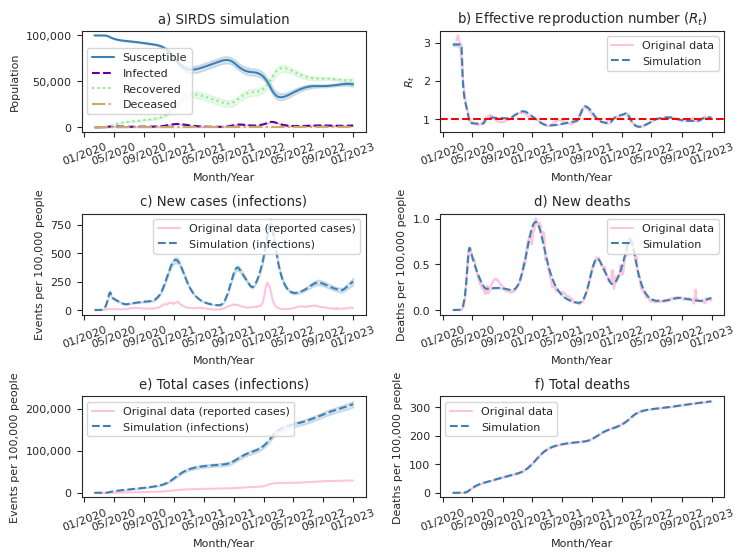

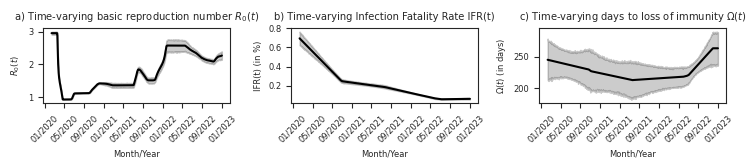

In [81]:
dict_last_prevalence_study = {'Spain': pd.to_datetime('2020-06-22'), 'United Kingdom': pd.to_datetime('2020-09-18'), 'United States': pd.to_datetime('2020-07-31')}

for country in df_fitting_other_countries.location.unique():
    print(country)
    df_results = df_fitting_other_countries[df_fitting_other_countries.location == country]
    date_first_case = pd.to_datetime(df_results.date_first_case.unique()[0])
    
    df_covid_country = df_covid_other_countries[(df_covid_other_countries.location == country) & (df_covid_other_countries.date >= date_first_case)]
    real_reproduction_number = df_covid_country.NUMERO_REPRODUCAO_EFETIVO_ATRASADO_MEDIA.values
    real_new_deaths = df_covid_country.rate_new_deaths_moving_average.values
    real_total_deaths = df_covid_country.rate_new_deaths_moving_average.cumsum().values
    real_new_cases = df_covid_country.rate_new_cases_moving_average.values
    real_total_cases = df_covid_country.rate_new_cases_moving_average.cumsum().values
        
    df_S = pd.DataFrame()
    df_I = pd.DataFrame()
    df_R = pd.DataFrame()
    df_D = pd.DataFrame()
    df_I_accumulated = pd.DataFrame()
    df_new_deaths = pd.DataFrame()
    df_rt = pd.DataFrame()
    df_new_cases = pd.DataFrame()
    df_r0 = pd.DataFrame()
    df_IFR = pd.DataFrame()
    df_Omega = pd.DataFrame()
    list_fuzzy_fast_transition = []
    list_fuzzy_slow_transition = []
    
    dict_performance = {'mae_fit': [], 'sse_D_fit': [], 'r2_D_fit': [], 'sse_Rt_fit': [], 'r2_Rt_fit': []}
    
    for index, result in df_results.iterrows():
        result = result.dropna()
        
        y = get_sirds(result)
        S, I, R, D, I_accumulated = y
        min_length = min(len(real_new_deaths), len(D))
        S = S[:min_length]
        I = I[:min_length]
        R = R[:min_length]
        D = D[:min_length]
        I_accumulated = I_accumulated[:min_length]
        N = S[0] + I[0] + R[0] + D[0]
        
        dates = df_covid_country[:min_length].date.values
        
        D_new_deaths, reproduction_number_sird, I_new_cases, epidemic_periods_with_fast_transition_fuzzy_variable, epidemic_periods_with_slow_transition_fuzzy_variable, days_between_infections_values, case_fatality_probability_values, loss_immunity_in_days_values, estimated_days_between_infections, estimated_case_fatality_probability, estimated_loss_immunity_in_days = get_sirds_extras(result, S, D, I_accumulated)
        
        df_S_temp = pd.DataFrame({'date': dates, 'S': S})
        df_I_temp = pd.DataFrame({'date': dates, 'I': I})
        df_R_temp = pd.DataFrame({'date': dates, 'R': R})
        df_D_temp = pd.DataFrame({'date': dates, 'D': D})
        df_I_accumulated_temp = pd.DataFrame({'date': dates, 'I_accumulated': I_accumulated})
        df_new_deaths_temp = pd.DataFrame({'date': dates[1:], 'deaths': D_new_deaths})
        df_rt_temp = pd.DataFrame({'date': dates, 'rt': reproduction_number_sird})
        df_new_cases_temp = pd.DataFrame({'date': dates[1:], 'cases': I_new_cases})
        df_r0_temp = pd.DataFrame({'date': dates, 'r0': days_to_recovery/estimated_days_between_infections}) 
        df_IRF_temp = pd.DataFrame({'date': dates, 'ifr': estimated_case_fatality_probability})
        df_Omega_temp = pd.DataFrame({'date': dates, 'Omega': estimated_loss_immunity_in_days})
                   
        df_S = pd.concat([df_S, df_S_temp])
        df_I = pd.concat([df_I, df_I_temp])
        df_R = pd.concat([df_R, df_R_temp])
        df_D = pd.concat([df_D, df_D_temp])
        df_I_accumulated = pd.concat([df_I_accumulated, df_I_accumulated_temp])
        df_new_deaths = pd.concat([df_new_deaths, df_new_deaths_temp])
        df_rt = pd.concat([df_rt, df_rt_temp])
        df_new_cases = pd.concat([df_new_cases, df_new_cases_temp])
        df_r0 = pd.concat([df_r0, df_r0_temp])
        df_IFR = pd.concat([df_IFR, df_IRF_temp])
        df_Omega = pd.concat([df_Omega, df_Omega_temp])
        list_fuzzy_fast_transition.append(epidemic_periods_with_fast_transition_fuzzy_variable)
        list_fuzzy_slow_transition.append(epidemic_periods_with_slow_transition_fuzzy_variable)
        
        mae_fit, sse_D_fit, r2_D_fit, sse_Rt_fit, r2_Rt_fit = calculate_performance(real_new_deaths, D_new_deaths, real_reproduction_number,  reproduction_number_sird)
        dict_performance['mae_fit'].append(mae_fit)
        dict_performance['sse_D_fit'].append(sse_D_fit)
        dict_performance['r2_D_fit'].append(r2_D_fit)
        dict_performance['sse_Rt_fit'].append(sse_Rt_fit)
        dict_performance['r2_Rt_fit'].append(r2_Rt_fit)  
        
    show_performance(dict_performance)
    
    
    
    last_prevalence_study_country = dict_last_prevalence_study[country]
    df_prevalence_analysis_simulation_temp = df_I_accumulated[df_I_accumulated.date <= last_prevalence_study_country].copy()
    df_prevalence_analysis_simulation_temp['country'] = country
    df_prevalence_analysis_simulation = pd.concat([df_prevalence_analysis_simulation, df_prevalence_analysis_simulation_temp])
    
    df_prevalence_analysis_real_temp = df_covid_country[df_covid_country.date <= last_prevalence_study_country][['date', 'rate_new_cases_moving_average']].copy()
    df_prevalence_analysis_real_temp['country'] = country
    df_prevalence_analysis_real_temp['rate_new_cases_moving_average'] = df_prevalence_analysis_real_temp['rate_new_cases_moving_average'].cumsum() 
    df_prevalence_analysis_real = pd.concat([df_prevalence_analysis_real, df_prevalence_analysis_real_temp])        
    plot_fuzzy_variables(dates, list_fuzzy_fast_transition, list_fuzzy_slow_transition, country)

    plot_result(df_S, df_I, df_R, df_D, df_new_deaths, df_I_accumulated, real_new_deaths[:min_length], real_total_deaths[:min_length], real_reproduction_number[:min_length], df_rt, real_total_cases[:min_length], real_new_cases[:min_length], df_new_cases, df_covid_country[:min_length].date.values, id_in_file=country)

    plot_parameters(df_r0, df_IFR, df_Omega, country)

## Assessing the seroprevalence

In [82]:
df_prevalence_studies = pd.DataFrame({'country': ['Brazil', 'Brazil', 'Spain', 'United Kingdom', 'United Kingdom', 'United Kingdom', 'United Kingdom', 'United States', 'United States'], 'begin': [pd.to_datetime('2020-05-14'), pd.to_datetime('2020-06-04'), pd.to_datetime('2020-04-27'), pd.to_datetime('2020-05-06'), pd.to_datetime('2020-06-04'), pd.to_datetime('2020-08-05'), pd.to_datetime('2020-08-24'), pd.to_datetime('2020-05-27'), pd.to_datetime('2020-07-01')], 'end': [pd.to_datetime('2020-05-21'), pd.to_datetime('2020-06-07'), pd.to_datetime('2020-06-22'), pd.to_datetime('2020-05-29'), pd.to_datetime('2020-06-29'), pd.to_datetime('2020-08-28'), pd.to_datetime('2020-09-18'), pd.to_datetime('2020-07-01'), pd.to_datetime('2020-07-31')], 'prevalence_per_100k': [1900, 3100, 6000, 8300, 7600, 5700, 6100, 5800, 9300], 'prevalence_per_100k_lower': [1700, 2800, 5700, 7500, 6900, 5000, 5400, 5400, 8800], 'prevalence_per_100k_upper': [2100, 3400, 6400, 9200, 8400, 6300, 6800, 6200, 9900]})

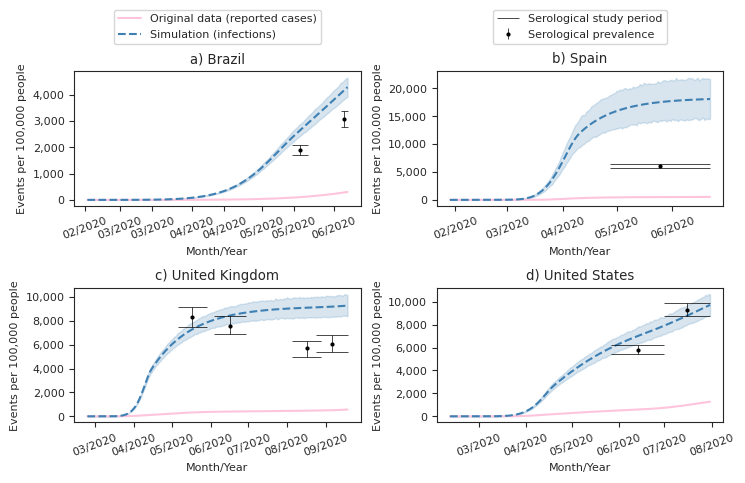

In [83]:
mask_date = mdates.DateFormatter('%m/%Y')
line_styles = ['-', '--', ':', '-.', '-']
plt.rc('font', size=8)
sns.set_style("ticks")
sns.set_palette(util.get_default_colors_categorical_seaborn())

subplots = ['a', 'b', 'c', 'd']

fig, ax = plt.subplots(2, 2, figsize=(util.centimeter_to_inch(19.05), util.centimeter_to_inch(12.93)), sharex=False)

for i, country in enumerate(['Brazil', 'Spain', 'United Kingdom', 'United States']):
    df_prevalence_analysis_real_country = df_prevalence_analysis_real[df_prevalence_analysis_real.country == country]
    df_prevalence_analysis_simulation_country = df_prevalence_analysis_simulation[df_prevalence_analysis_simulation.country == country]

    sns.lineplot(data=df_prevalence_analysis_real_country, x='date', y='rate_new_cases_moving_average', label='Original data (reported cases)', legend=(i==0), linestyle=line_styles[0], ax=ax.flatten()[i])
    sns.lineplot(data=df_prevalence_analysis_simulation_country, x='date', y='I_accumulated', label='Simulation (infections)', legend=(i==0), linestyle=line_styles[1], ax=ax.flatten()[i], errorbar=('ci', 95))
    
    df_prevalence_studies_country = df_prevalence_studies[df_prevalence_studies.country == country].reset_index(drop=True)
    
    for index, prevalence_study in df_prevalence_studies_country.iterrows():
        reference_values = prevalence_study.prevalence_per_100k
        reference_ci_lower = prevalence_study.prevalence_per_100k_lower
        reference_ci_upper = prevalence_study.prevalence_per_100k_upper
        reference_start = prevalence_study.begin
        reference_end = prevalence_study.end
        quantity_days = (reference_end - reference_start).days
        reference_middle = reference_start + pd.DateOffset(days=quantity_days/2)
        if (index == 0) & (i == 1):
            label_prevalence =  'Serological prevalence'
            label_period = 'Serological study period' 
        else:
            label_prevalence = None
            label_period = None
        ax.flatten()[i].errorbar(x=reference_middle, y=reference_values, yerr=[[reference_values - reference_ci_lower], [reference_ci_upper - reference_values]], fmt='o', color='black', markersize=2, label=label_prevalence,  linewidth=0.5)
        ax.flatten()[i].hlines(y=reference_ci_lower, xmin=reference_start, xmax=reference_end, color='black', linestyle='-', label=label_period, linewidth=0.5)
        ax.flatten()[i].hlines(y=reference_ci_upper, xmin=reference_start, xmax=reference_end, color='black', linestyle='-',  linewidth=0.5)
    
    ax.flatten()[i].set_xlabel('Month/Year')
    ax.flatten()[i].xaxis.set_major_formatter(mask_date)
    ax.flatten()[i].tick_params(axis='x', labelrotation=20)
    ax.flatten()[i].set_ylabel('Events per 100,000 people')
    ax.flatten()[i].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax.flatten()[i].set_title(subplots[i] + ') ' + country)
    if i == 0:         
        ax.flatten()[i].legend(ncols=1, loc='upper center', bbox_to_anchor=(0.5, 1.5))
    elif i == 1:
        handles, labels = ax.flatten()[i].get_legend_handles_labels()
        ax.flatten()[i].legend(handles[2:], labels[2:], ncols=1, loc='upper center', bbox_to_anchor=(0.5, 1.5))

fig.tight_layout()
filename = 'images/prevalence_analysis'
plt.savefig(filename+'.pdf', bbox_inches="tight")
plt.savefig(filename+'.tiff', format='tiff', dpi=300, transparent=False, bbox_inches='tight')
img = Image.open(filename+".tiff")
img.save(filename+"_compressed.tiff", compression="tiff_lzw")
plt.show()

In [84]:
df_prevalence_analysis_simulation

,date,I_accumulated,country
0,2020-02-16,0.032103,Brazil
1,2020-02-17,0.042563,Brazil
2,2020-02-18,0.054998,Brazil
3,2020-02-19,0.069791,Brazil
4,2020-02-20,0.087388,Brazil
...,...,...,...
167,2020-07-27,8152.948262,United States
168,2020-07-28,8208.646214,United States
169,2020-07-29,8264.627091,United States
170,2020-07-30,8320.890894,United States


In [85]:
I_accumulated_spain = df_prevalence_analysis_simulation[(df_prevalence_analysis_simulation.country == 'Spain') & (df_prevalence_analysis_simulation.date == pd.to_datetime('2020-04-27'))].I_accumulated.values
I_accumulated_spain

array([ 8187.09184874, 28835.46631633, 13543.2153624 , 24729.27775425,
       30816.53366211, 11169.25930812, 12012.50966032,  5998.24176033,
        8079.52873169,  8296.6532071 , 13172.98820355, 21407.76536201,
       12430.96880607, 15398.57053567, 25871.01029683,  7329.65064732,
       12451.69612659, 16951.13572671, 12112.78958619, 20401.32452077])

In [86]:
mean = np.mean(I_accumulated_spain)
lower_bound, upper_bound = util.calculate_confidence_interval(I_accumulated_spain)
print(mean, '(', lower_bound, ',', upper_bound, ')')

15459.783871153855 ( 12439.604627914416 , 18785.89932045244 )
